# Bike Availability Preprocessing

## Data Dictionary

The raw data contains the following data per station per reading:

* Id - String - API Resource Id
* Name - String - The common name of the station
* PlaceType - String ?
* TerminalName - String - ?
* NbBikes - Integer - The number of available bikes
* NbDocks - Integer - The total number of docking spaces
* NbEmptyDocks - Integer - The number of available empty docking spaces
* Timestamp - DateTime - The moment this reading was captured
* InstallDate - DateTime - Date when the station was installed
* RemovalDate - DateTime - Date when the station was removed
* Installed - Boolean - If the station is installed or not
* Locked - Boolean - ?
* Temporary - Boolean - If the station is temporary or not (TfL adds temporary stations to cope with demand.)
* Latitude - Float - Latitude Coordinate
* Longitude - Float - Longitude Coordinate

The following variables will be derived from the raw data.

* NbUnusableDocks - Integer - The number of non-working docking spaces. Computed with NbUnusableDocks = NbDocks - (NbBikes + NbEmptyDocks)

## Set up

### Imports

In [4]:
%matplotlib inline

import logging
import itertools
import json
import os
import pickle
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from datetime import datetime
from os import listdir
from os.path import isfile, join
from IPython.display import Image
from datetime import date

from src.data.parse_dataset import parse_dir, parse_json_files, get_file_list
from src.data.string_format import format_name, to_short_name
from src.data.visualization import lon_min_longitude, lon_min_latitude, lon_max_longitude, lon_max_latitude, lon_center_latitude, lon_center_longitude, create_london_map

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Parse Raw Data 

### Define the Parsing Functions

In [52]:
def parse_cycles(json_obj):
    """Parses TfL's BikePoint JSON response"""

    return [parse_station(element) for element in json_obj]

def parse_station(element):
    """Parses a JSON bicycle station object to a dictionary"""

    obj = {
        'Id': element['id'],
        'Name': element['commonName'],
        'Latitude': element['lat'],
        'Longitude': element['lon'],
        'PlaceType': element['placeType'],
    }

    for p in element['additionalProperties']:
        obj[p['key']] = p['value']

        if 'timestamp' not in obj:
            obj['Timestamp'] = p['modified']
        elif obj['Timestamp'] != p['modified']:
            raise ValueError('The properties\' timestamps for station %s do not match: %s != %s' % (
            obj['id'], obj['Timestamp'], p['modified']))

    return obj

In [53]:
def bike_file_date_fn(file_name):
    """Gets the file's date"""

    return datetime.strptime(os.path.basename(file_name), 'BIKE-%Y-%m-%d:%H:%M:%S.json')

def create_between_dates_filter(file_date_fn, date_start, date_end):
    def filter_fn(file_name):
        file_date = file_date_fn(file_name)
        return file_date >= date_start and file_date <= date_end
    
    return filter_fn

### Quick Data View

#### Load Single Day Data

In [54]:
filter_fn = create_between_dates_filter(bike_file_date_fn, 
                                       datetime(2016, 5, 16, 7, 0, 0),
                                       datetime(2016, 5, 16, 23, 59, 59))

records = parse_dir('/home/jfconavarrete/Documents/Work/Dissertation/spts-uoe/data/raw/cycles', 
                    parse_cycles, sort_fn=bike_file_date_fn, filter_fn=filter_fn)

# records is a list of lists of dicts
df = pd.DataFrame(list(itertools.chain.from_iterable(records))) 

####  All Station View

In [55]:
df.head()

,Id,InstallDate,Installed,Latitude,Locked,Longitude,Name,NbBikes,NbDocks,NbEmptyDocks,PlaceType,RemovalDate,Temporary,TerminalName,Timestamp
0,BikePoints_1,1278947280000,true,51.529163,false,-0.109970,"River Street , Clerkenwell",11,19,7,BikePoint,,false,001023,2016-05-16T06:26:24.037
1,BikePoints_2,1278585780000,true,51.499606,false,-0.197574,"Phillimore Gardens, Kensington",12,37,25,BikePoint,,false,001018,2016-05-16T06:26:24.037
2,BikePoints_3,1278240360000,true,51.521283,false,-0.084605,"Christopher Street, Liverpool Street",6,32,26,BikePoint,,false,001012,2016-05-16T06:51:27.5
3,BikePoints_4,1278241080000,true,51.530059,false,-0.120973,"St. Chad's Street, King's Cross",14,23,9,BikePoint,,false,001013,2016-05-16T06:51:27.5
4,BikePoints_5,1278241440000,true,51.493130,false,-0.156876,"Sedding Street, Sloane Square",27,27,0,BikePoint,,false,003420,2016-05-16T06:46:27.237


####  Single Station View

In [56]:
df[df['Id'] == 'BikePoints_1'].head()

,Id,InstallDate,Installed,Latitude,Locked,Longitude,Name,NbBikes,NbDocks,NbEmptyDocks,PlaceType,RemovalDate,Temporary,TerminalName,Timestamp
0,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",11,19,7,BikePoint,,false,001023,2016-05-16T06:26:24.037
762,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",11,19,7,BikePoint,,false,001023,2016-05-16T06:26:24.037
1524,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",10,19,8,BikePoint,,false,001023,2016-05-16T07:01:29.163
2286,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",8,19,10,BikePoint,,false,001023,2016-05-16T07:11:30.433
3048,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",8,19,10,BikePoint,,false,001023,2016-05-16T07:11:30.433


#### Observations

* There are some duplicate rows <- remove duplicates
* RemovalDate may contain a lot of nulls <- remove if not helpful
* Locked and Installed might be constant <- remove if not helpful

### Build Dataset

#### Work with Chunks

Due to memory constraints we'll parse the data in chunks. In each chunk we'll remove the redundant candidate keys and also duplicate rows.

In [57]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in xrange(0, len(seq), size))

#### Tables

We will have two different tables, one for the stations and one for the availability readings

In [58]:
def split_data(parsed_data):
    master_df = pd.DataFrame(list(itertools.chain.from_iterable(parsed_data)))
    
    readings_df = pd.DataFrame(master_df, columns=['Id', 'Timestamp', 'NbBikes', 'NbDocks', 'NbEmptyDocks'])
    stations_df = pd.DataFrame(master_df, columns=['Id', 'Name', 'TerminalName' , 'PlaceType', 'Latitude', 
                                                   'Longitude', 'Installed', 'Temporary', 'Locked',
                                                   'RemovalDate', 'InstallDate'])
    
    return (readings_df, stations_df)

#### Build the Dataset

In [59]:
# get the files to parse
five_weekdays_filter = create_between_dates_filter(bike_file_date_fn, 
                                                   datetime(2016, 6, 19, 0, 0, 0), 
                                                   datetime(2016, 6, 27, 23, 59, 59))

files = get_file_list('data/raw/cycles', filter_fn=None, sort_fn=bike_file_date_fn)

# process the files in chunks
files_batches = chunker(files, 500)

In [60]:
# start with an empty dataset
readings_dataset = pd.DataFrame()
stations_dataset = pd.DataFrame()

# append each chunk to the datasets while removing duplicates
for batch in files_batches:
    parsed_data = parse_json_files(batch, parse_cycles)
    
    # split the data into two station data and readings data
    readings_df, stations_df = split_data(parsed_data)
    
    # append the datasets
    readings_dataset = pd.concat([readings_dataset, readings_df])
    stations_dataset = pd.concat([stations_dataset, stations_df])
    
    # remove duplicated rows
    readings_dataset.drop_duplicates(inplace=True)
    stations_dataset.drop_duplicates(inplace=True)

In [61]:
# put the parsed data in pickle files
pickle.dump(readings_dataset, open("data/parsed/readings_dataset_raw.p", "wb"))
pickle.dump(stations_dataset, open("data/parsed/stations_dataset_raw.p", "wb"))

## Read the Parsed Data

In [15]:
stations_dataset = pickle.load(open('data/parsed/stations_dataset_raw.p', 'rb'))
readings_dataset = pickle.load(open('data/parsed/readings_dataset_raw.p', 'rb'))

## Technically Correct Data

The data is set to be technically correct if it:

1. can be directly recognized as belonging to a certain variable
2. is stored in a data type that represents the value domain of the real-world variable.

In [16]:
# convert columns to their appropriate datatypes
stations_dataset['InstallDate'] = pd.to_numeric(stations_dataset['InstallDate'], errors='raise')
stations_dataset['RemovalDate'] = pd.to_numeric(stations_dataset['RemovalDate'], errors='raise')

stations_dataset['Installed'].replace({'true': True, 'false': False}, inplace=True)
stations_dataset['Temporary'].replace({'true': True, 'false': False}, inplace=True)
stations_dataset['Locked'].replace({'true': True, 'false': False}, inplace=True)

readings_dataset['NbBikes'] = readings_dataset['NbBikes'].astype('uint16')
readings_dataset['NbDocks'] = readings_dataset['NbDocks'].astype('uint16')
readings_dataset['NbEmptyDocks'] = readings_dataset['NbEmptyDocks'].astype('uint16')

In [17]:
# format station name
stations_dataset['Name'] = stations_dataset['Name'].apply(format_name)

In [18]:
# convert string timestamp to datetime
stations_dataset['InstallDate'] = pd.to_datetime(stations_dataset['InstallDate'], unit='ms', errors='raise')
stations_dataset['RemovalDate'] = pd.to_datetime(stations_dataset['RemovalDate'], unit='ms', errors='raise')

readings_dataset['Timestamp'] =  pd.to_datetime(readings_dataset['Timestamp'], format='%Y-%m-%dT%H:%M:%S.%f', errors='raise')

In [19]:
# sort the datasets
stations_dataset.sort_values(by=['Id'], ascending=True, inplace=True)

readings_dataset.sort_values(by=['Timestamp'], ascending=True, inplace=True)

## Derive Data

In [20]:
stations_dataset['ShortName'] = stations_dataset['Name'].apply(to_short_name)

readings_dataset['NbUnusableDocks'] = readings_dataset['NbDocks'] - (readings_dataset['NbBikes'] + readings_dataset['NbEmptyDocks'])

### Add Station Priority Column
Priorities downloaded from https://www.whatdotheyknow.com/request/tfl_boris_bike_statistics?unfold=1

In [21]:
stations_priorities = pd.read_csv('data/raw/priorities/station_priorities.csv', encoding='latin-1')
stations_priorities['Site'] = stations_priorities['Site'].apply(format_name)

In [22]:
stations_dataset = pd.merge(stations_dataset, stations_priorities, how='left', left_on='ShortName', right_on='Site')
stations_dataset['Priority'].replace({'One': '1', 'Two': '2', 'Long Term Suspended': np.NaN, 'Long term suspension': np.NaN}, inplace=True)
stations_dataset.drop(['Site'], axis=1, inplace=True)
stations_dataset.drop(['Borough'], axis=1, inplace=True)

In [24]:
stations_dataset

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
0,BikePoints_1,"River Street, Clerkenwell",001023,BikePoint,51.529163,-0.109970,True,False,False,NaT,2010-07-12 15:08:00,River Street,2.0
1,BikePoints_10,"Park Street, Bankside",001024,BikePoint,51.505974,-0.092754,True,False,False,NaT,2010-07-04 11:21:00,Park Street,2.0
2,BikePoints_100,"Albert Embankment, Vauxhall",001059,BikePoint,51.490435,-0.122806,True,False,False,NaT,2010-07-14 09:31:00,Albert Embankment,2.0
3,BikePoints_101,"Queen Street 1, Bank",000999,BikePoint,51.511553,-0.092940,True,False,False,NaT,2010-07-14 10:18:00,Queen Street,1.0
4,BikePoints_102,"Jewry Street, Aldgate",001045,BikePoint,51.513406,-0.076793,True,False,False,NaT,2010-07-14 10:21:00,Jewry Street,2.0
5,BikePoints_103,"Vicarage Gate, Kensington",003441,BikePoint,51.504723,-0.192538,True,False,False,NaT,2010-07-14 10:32:00,Vicarage Gate,2.0
6,BikePoints_104,"Crosswall, Tower",000991,BikePoint,51.511594,-0.077121,True,False,False,NaT,2010-07-14 10:36:00,Crosswall,1.0
7,BikePoints_105,"Westbourne Grove, Bayswater",001041,BikePoint,51.515529,-0.190240,True,False,False,NaT,2010-07-14 11:02:00,Westbourne Grove,2.0
8,BikePoints_106,"Woodstock Street, Mayfair",001042,BikePoint,51.514105,-0.147301,True,False,False,NaT,2010-07-14 11:28:00,Woodstock Street,2.0
9,BikePoints_107,"Finsbury Leisure Centre, St. Lukes",001049,BikePoint,51.526008,-0.096317,True,False,False,NaT,2010-07-14 11:38:00,Finsbury Leisure Centre,2.0


## Consistent Data

### Stations Analysis

#### Overview

In [25]:
stations_dataset.shape

(789, 13)

In [26]:
stations_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789 entries, 0 to 788
Data columns (total 13 columns):
Id              789 non-null object
Name            789 non-null object
TerminalName    789 non-null object
PlaceType       789 non-null object
Latitude        789 non-null float64
Longitude       789 non-null float64
Installed       789 non-null bool
Temporary       789 non-null bool
Locked          789 non-null bool
RemovalDate     3 non-null datetime64[ns]
InstallDate     690 non-null datetime64[ns]
ShortName       789 non-null object
Priority        733 non-null float64
dtypes: bool(3), datetime64[ns](2), float64(3), object(5)
memory usage: 488.5 KB


In [27]:
stations_dataset.head()

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
0,BikePoints_1,"River Street, Clerkenwell",001023,BikePoint,51.529163,-0.109970,True,False,False,NaT,2010-07-12 15:08:00,River Street,2.0
1,BikePoints_10,"Park Street, Bankside",001024,BikePoint,51.505974,-0.092754,True,False,False,NaT,2010-07-04 11:21:00,Park Street,2.0
2,BikePoints_100,"Albert Embankment, Vauxhall",001059,BikePoint,51.490435,-0.122806,True,False,False,NaT,2010-07-14 09:31:00,Albert Embankment,2.0
3,BikePoints_101,"Queen Street 1, Bank",000999,BikePoint,51.511553,-0.092940,True,False,False,NaT,2010-07-14 10:18:00,Queen Street,1.0
4,BikePoints_102,"Jewry Street, Aldgate",001045,BikePoint,51.513406,-0.076793,True,False,False,NaT,2010-07-14 10:21:00,Jewry Street,2.0


In [28]:
stations_dataset.describe()

,Latitude,Longitude,Priority
count,789.000000,789.000000,733.000000
mean,51.440649,-0.128648,1.896317
std,1.833769,0.056337,0.305058
min,0.000000,-0.236769,1.000000
25%,51.493184,-0.173029,2.000000
50%,51.509301,-0.131961,2.000000
75%,51.520858,-0.092762,2.000000
max,51.549369,0.122299,2.000000


In [29]:
stations_dataset.apply(lambda x:x.nunique())

Id              780
Name            782
TerminalName    780
PlaceType         1
Latitude        778
Longitude       778
Installed         2
Temporary         1
Locked            2
RemovalDate       3
InstallDate     686
ShortName       770
Priority          2
dtype: int64

In [30]:
stations_dataset.isnull().sum()

Id                0
Name              0
TerminalName      0
PlaceType         0
Latitude          0
Longitude         0
Installed         0
Temporary         0
Locked            0
RemovalDate     786
InstallDate      99
ShortName         0
Priority         56
dtype: int64

#### Observations:
* Id, Name and Terminal name seem to be candidate keys
* The minimum latitude and the maximum longitude are 0
* Some stations have the same latitude or longitude
* Id, TerminalName and Name have different unique values
* Placetype, Installed, Temporary and Locked appear to be constant
* Some stations do not have an install date
* Some Stations have a removal date (very sparse)

#### Remove Duplicate Stations

In [31]:
def find_duplicate_ids(df):
    """Find Ids that have more than one value in the given columns"""
    
    df = df.drop_duplicates()
    value_counts_grouped_by_id = df.groupby('Id').count()    
    is_duplicate_id = value_counts_grouped_by_id.applymap(lambda x: x > 1).any(axis=1)
    duplicate_ids = value_counts_grouped_by_id[is_duplicate_id == True].index.values
    return df[df['Id'].isin(duplicate_ids)]

diplicate_ids = find_duplicate_ids(stations_dataset)
diplicate_ids

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
150,BikePoints_237,"Dock Street, Wapping",003467,BikePoint,51.509786,-0.068161,True,False,False,NaT,2010-07-22 11:44:00,Dock Street,NaN
151,BikePoints_237,"Dock Street, Wapping",003467,BikePoint,51.509786,-0.068161,True,False,False,NaT,2010-07-20 11:44:00,Dock Street,NaN
417,BikePoints_497,"Merchant Street, Bow",200242,BikePoint,51.526535,-0.028619,True,False,False,NaT,2012-01-24 09:47:00,Merchant Street,NaN
418,BikePoints_497,"Merchant Street, Bow",200242,BikePoint,51.526177,-0.027467,True,False,False,NaT,2012-01-24 09:47:00,Merchant Street,NaN
726,BikePoints_780,Imperial Wharf Station,300070,BikePoint,51.474665,-0.183165,True,False,False,NaT,2015-08-13 08:40:00,Imperial Wharf Station,2.0
727,BikePoints_780,"Imperial Wharf Station, Sands End",300070,BikePoint,51.474665,-0.183165,True,False,False,NaT,2015-08-13 08:40:00,Imperial Wharf Station,2.0
743,BikePoints_796,"Coram Street, Bloomsbury",300201,BikePoint,51.524000,-0.126409,True,False,True,NaT,2016-02-29 11:47:00,Coram Street,NaN
744,BikePoints_796,"Coram Street, Bloomsbury",300201,BikePoint,51.524000,-0.126409,True,False,False,NaT,2016-02-29 11:47:00,Coram Street,NaN
745,BikePoints_798,"Birkenhead Street, Kings Cross",300212,BikePoint,51.530199,0.122299,True,False,False,NaT,NaT,Birkenhead Street,NaN
746,BikePoints_798,"Birkenhead Street, Kings Cross",300212,BikePoint,51.530199,-0.122299,True,False,False,NaT,NaT,Birkenhead Street,NaN


Given these records have the same location and Id but different Name or TerminalName, we'll assume the station changed name and remove the first entries.

In [32]:
# remove the one not in merchant street
stations_dataset.drop(417, inplace=True)

# remove the one with the shortest name
stations_dataset.drop(726, inplace=True)

# remove the one that is not in kings cross (as the name of the station implies)
stations_dataset.drop(745, inplace=True)

# remove the duplicated entries 
stations_dataset.drop([747, 743, 151, 754, 765, 768],  inplace=True)

In [33]:
# make sure there are no repeated ids 
assert len(find_duplicate_ids(stations_dataset)) == 0

#### Check Locations

Let's have a closer look at the station locations. All of them should be in Greater London.

In [34]:
def find_locations_outside_box(locations, min_longitude, min_latitude, max_longitude, max_latitude):
    latitude_check = ~(locations['Latitude'] >= min_latitude) & (locations['Latitude'] <= max_latitude) 
    longitude_check = ~(locations['Longitude'] >= min_longitude) & (locations['Longitude'] <= max_longitude) 
    return locations[(latitude_check | longitude_check)]

outlier_locations_df = find_locations_outside_box(stations_dataset, lon_min_longitude, lon_min_latitude, 
                                                  lon_max_longitude, lon_max_latitude)
outlier_locations_df

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
738,BikePoints_791,Test Desktop,666666,BikePoint,0.0,0.0,False,False,False,NaT,2016-01-15 12:39:00,Test Desktop,NaN


This station looks like a test dation, so we'll remove it.

In [35]:
outlier_locations_idx = outlier_locations_df.index.values

stations_dataset.drop(outlier_locations_idx, inplace=True)

In [36]:
# make sure there are no stations outside London
assert len(find_locations_outside_box(stations_dataset, lon_min_longitude, lon_min_latitude, 
                                      lon_max_longitude, lon_max_latitude)) == 0

We will investigate the fact that there are stations with duplicate latitude or longitude values.

In [37]:
# find stations with duplicate longitude
id_counts_groupedby_longitude = stations_dataset.groupby('Longitude')['Id'].count()
nonunique_longitudes = id_counts_groupedby_longitude[id_counts_groupedby_longitude != 1].index.values
nonunique_longitude_stations = stations_dataset[stations_dataset['Longitude'].isin(nonunique_longitudes)].sort_values(by=['Longitude'])

id_counts_groupedby_latitude = stations_dataset.groupby('Latitude')['Id'].count()
nonunique_latitudes = id_counts_groupedby_latitude[id_counts_groupedby_latitude != 1].index.values
nonunique_latitudes_stations = stations_dataset[stations_dataset['Latitude'].isin(nonunique_latitudes)].sort_values(by=['Latitude'])

nonunique_coordinates_stations = pd.concat([nonunique_longitude_stations, nonunique_latitudes_stations])
nonunique_coordinates_stations

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
127,BikePoints_216,"Old Brompton Road, South Kensington",003479,BikePoint,51.490945,-0.181190,True,False,False,NaT,2010-07-19 11:12:00,Old Brompton Road,2.0
500,BikePoints_573,"Limerston Street, West Chelsea",200001,BikePoint,51.485587,-0.181190,True,False,False,NaT,2012-03-15 07:21:00,Limerston Street,2.0
120,BikePoints_21,"Hampstead Road (Cartmel), Euston",003426,BikePoint,51.530078,-0.138846,True,False,False,NaT,2010-07-06 14:49:00,Hampstead Road (Cartmel),2.0
237,BikePoints_318,"Sackville Street, Mayfair",001197,BikePoint,51.510048,-0.138846,True,False,False,NaT,2010-07-23 11:42:00,Sackville Street,2.0
10,BikePoints_108,"Abbey Orchard Street, Westminster",003429,BikePoint,51.498125,-0.132102,True,False,False,NaT,2010-07-14 11:42:00,Abbey Orchard Street,1.0
554,BikePoints_624,"Courland Grove, Wandsworth Road",200173,BikePoint,51.472918,-0.132102,True,False,False,NaT,2013-10-08 09:24:00,Courland Grove,2.0
3,BikePoints_101,"Queen Street 1, Bank",000999,BikePoint,51.511553,-0.092940,True,False,False,NaT,2010-07-14 10:18:00,Queen Street,1.0
345,BikePoints_427,"Cheapside, Bank",022180,BikePoint,51.513970,-0.092940,True,False,False,NaT,2011-07-15 10:28:00,Cheapside,1.0
10,BikePoints_108,"Abbey Orchard Street, Westminster",003429,BikePoint,51.498125,-0.132102,True,False,False,NaT,2010-07-14 11:42:00,Abbey Orchard Street,1.0
393,BikePoints_474,"Castalia Square, Cubitt Town",200155,BikePoint,51.498125,-0.011457,True,False,False,NaT,2012-01-17 17:56:00,Castalia Square,2.0


In [38]:
def draw_stations_map(stations_df):    
    stations_map = create_london_map()

    for index, station in stations_df.iterrows():        
        folium.Marker([station['Latitude'],station['Longitude']], popup=station['Name']).add_to(stations_map)
    
    return stations_map

In [39]:
draw_stations_map(nonunique_coordinates_stations)

We can observe that the stations are different and that having the same Longitude is just a coincidence.

Let's plot all the stations in a map to see how it looks

In [40]:
london_longitude = -0.127722
london_latitude = 51.507981

MAX_RECORDS = 100

stations_map = create_london_map()

for index, station in stations_dataset[0:MAX_RECORDS].iterrows():
    folium.Marker([station['Latitude'],station['Longitude']], popup=station['Name']).add_to(stations_map)
    
stations_map

#folium.Map.save(stations_map, 'reports/maps/stations_map.html')

### Readings Analysis

#### Overview

In [41]:
readings_dataset.shape

(1529937, 6)

In [42]:
readings_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1529937 entries, 750 to 292193
Data columns (total 6 columns):
Id                 1529937 non-null object
Timestamp          1529937 non-null datetime64[ns]
NbBikes            1529937 non-null uint16
NbDocks            1529937 non-null uint16
NbEmptyDocks       1529937 non-null uint16
NbUnusableDocks    1529937 non-null uint16
dtypes: datetime64[ns](1), object(1), uint16(4)
memory usage: 203.4 MB


In [43]:
readings_dataset.head()

,Id,Timestamp,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
750,BikePoints_791,2016-05-10 15:34:07.137,0,0,0,0
608,BikePoints_646,2016-05-14 20:36:22.417,0,0,0,0
570,BikePoints_608,2016-05-14 23:18:18.467,14,29,15,0
666,BikePoints_704,2016-05-15 00:50:38.140,9,18,9,0
634,BikePoints_672,2016-05-15 04:11:04.447,28,28,0,0


In [44]:
readings_dataset.describe()

,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
count,1.529937e+06,1.529937e+06,1.529937e+06,1.529937e+06
mean,1.239987e+01,2.701473e+01,1.404461e+01,5.702444e-01
std,9.076213e+00,9.518489e+00,9.577277e+00,9.018525e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,2.000000e+01,7.000000e+00,0.000000e+00
50%,1.100000e+01,2.500000e+01,1.300000e+01,0.000000e+00
75%,1.800000e+01,3.300000e+01,1.900000e+01,1.000000e+00
max,6.400000e+01,6.400000e+01,6.400000e+01,3.800000e+01


In [45]:
readings_dataset.apply(lambda x:x.nunique())

Id                   780
Timestamp          13236
NbBikes               65
NbDocks               58
NbEmptyDocks          65
NbUnusableDocks       20
dtype: int64

In [46]:
readings_dataset.isnull().sum()

Id                 0
Timestamp          0
NbBikes            0
NbDocks            0
NbEmptyDocks       0
NbUnusableDocks    0
dtype: int64

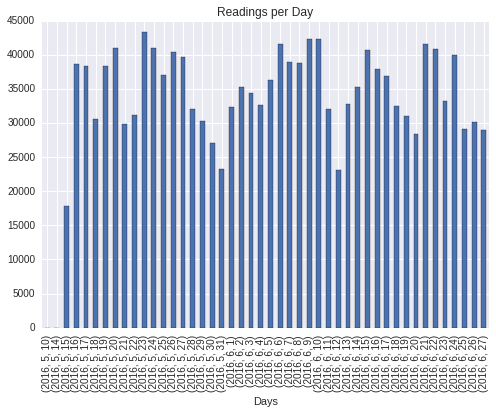

In [47]:
timestamps = readings_dataset['Timestamp']
ax = timestamps.groupby([timestamps.dt.year, timestamps.dt.month, timestamps.dt.day]).count().plot(kind="bar")
ax.set_xlabel('Days')
ax.set_title('Readings per Day')

#### Observations:
* The number of readings in each day varies widely

#### Discard Out of Range Data

In [48]:
start_date = date(2016, 5, 16)
end_date = date(2016, 6, 27)
days = set(pd.date_range(start=start_date, end=end_date, closed='left'))
           
readings_dataset = readings_dataset[(timestamps > start_date) & (timestamps < end_date)]

#### Readings Consistency Through Days
Lets get some insight about which stations do not have readings during an entire day

In [49]:
# get a subview of the readings dataset
id_timestamp_view = readings_dataset.loc[:,['Id','Timestamp']]

# remove the time component of the timestamp
id_timestamp_view['Timestamp'] = id_timestamp_view['Timestamp'].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

# compute the days of readings per stations
days_readings = id_timestamp_view.groupby('Id').aggregate(lambda x: set(x))
days_readings['MissingDays'] = days_readings['Timestamp'].apply(lambda x: list(days - x))
days_readings['MissingDaysCount'] = days_readings['MissingDays'].apply(lambda x: len(x))

In [50]:
def expand_datetime(df, datetime_col):
    df['Weekday'] = df[datetime_col].apply(lambda x: x.weekday())
    return df

In [51]:
# get the stations with missing readings only
missing_days_readings = days_readings[days_readings['MissingDaysCount'] != 0]
missing_days_readings = missing_days_readings['MissingDays'].apply(lambda x: pd.Series(x)).unstack().dropna()
missing_days_readings.index = missing_days_readings.index.droplevel()

# sort and format in their own DF
missing_days_readings = pd.DataFrame(missing_days_readings, columns=['MissingDay'], index=None).reset_index().sort_values(by=['Id', 'MissingDay'])

# expand the missing day date
expand_datetime(missing_days_readings, 'MissingDay')

,Id,MissingDay,Weekday
0,BikePoints_109,2016-06-25,5
1,BikePoints_112,2016-05-25,2
52,BikePoints_112,2016-05-26,3
53,BikePoints_120,2016-06-10,4
2,BikePoints_120,2016-06-11,5
3,BikePoints_129,2016-06-25,5
54,BikePoints_133,2016-06-24,4
4,BikePoints_133,2016-06-25,5
88,BikePoints_133,2016-06-26,6
5,BikePoints_153,2016-06-17,4


In [52]:
missing_days_readings['Id'].nunique()

52

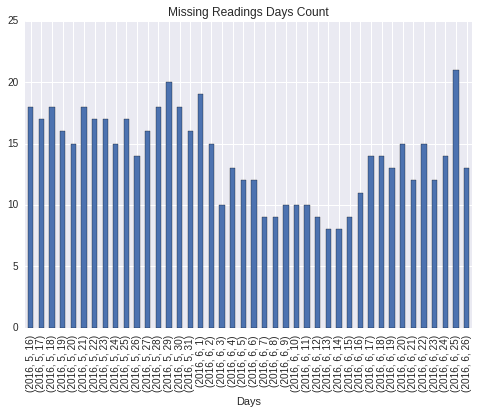

In [53]:
# plot the missing readings days 
days = missing_days_readings['MissingDay']
missing_days_counts = days.groupby([days.dt.year, days.dt.month, days.dt.day]).count()
ax = missing_days_counts.plot(kind="bar")
ax.set_xlabel('Days')
ax.set_title('Missing Readings Days Count')

Stations with no readings in at least one day

In [54]:
missing_days_readings_stations = stations_dataset[stations_dataset['Id'].isin(missing_days_readings['Id'].unique())]
draw_stations_map(missing_days_readings_stations)

Stations with no readings in at least one day during the weekend

In [55]:
weekend_readings = missing_days_readings[missing_days_readings['Weekday'] > 4]
missing_dayreadings_stn = stations_dataset[stations_dataset['Id'].isin(weekend_readings['Id'].unique())]
draw_stations_map(missing_dayreadings_stn)

Stations with no readings in at least one day during weekdays

In [56]:
weekday_readings = missing_days_readings[missing_days_readings['Weekday'] < 5]
missing_dayreadings_stn = stations_dataset[stations_dataset['Id'].isin(weekday_readings['Id'].unique())]
draw_stations_map(missing_dayreadings_stn)

Observations:
* There are 29 stations that do not have readings in at least one day
* There were more stations without readings during May than in June
* Other than that, there is no visible pattern

#### Discard Non Relevant Data

In [57]:
hour = readings_dataset['Timestamp'].apply(lambda x: x.hour)
selector = (hour < 7) | (hour > 22)
#readings_dataset.drop(readings_dataset[selector].index, inplace=True)

## Build Datasets
### Readings

In [58]:
readings_dataset.reset_index(inplace=True, drop=True)

In [59]:
readings_dataset.head()

,Id,Timestamp,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
0,BikePoints_482,2016-05-16 00:00:31.437,7,26,19,0
1,BikePoints_359,2016-05-16 00:00:31.437,3,18,15,0
2,BikePoints_534,2016-05-16 00:05:36.750,16,27,9,2
3,BikePoints_495,2016-05-16 00:05:36.750,12,38,26,0
4,BikePoints_441,2016-05-16 00:05:36.750,11,24,12,1


In [60]:
readings_dataset.describe()

,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
count,1.483149e+06,1.483149e+06,1.483149e+06,1.483149e+06
mean,1.241480e+01,2.701812e+01,1.403053e+01,5.727968e-01
std,9.092813e+00,9.520796e+00,9.583255e+00,9.038990e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,2.000000e+01,7.000000e+00,0.000000e+00
50%,1.100000e+01,2.500000e+01,1.300000e+01,0.000000e+00
75%,1.800000e+01,3.300000e+01,1.900000e+01,1.000000e+00
max,6.400000e+01,6.400000e+01,6.400000e+01,3.800000e+01


In [61]:
readings_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483149 entries, 0 to 1483148
Data columns (total 6 columns):
Id                 1483149 non-null object
Timestamp          1483149 non-null datetime64[ns]
NbBikes            1483149 non-null uint16
NbDocks            1483149 non-null uint16
NbEmptyDocks       1483149 non-null uint16
NbUnusableDocks    1483149 non-null uint16
dtypes: datetime64[ns](1), object(1), uint16(4)
memory usage: 185.8 MB


In [62]:
pickle.dump(readings_dataset, open("data/parsed/readings_dataset_final.p", "wb"))

### Stations

In [63]:
stations_dataset.reset_index(inplace=True, drop=True)

In [64]:
stations_dataset.head()

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
0,BikePoints_1,"River Street, Clerkenwell",001023,BikePoint,51.529163,-0.109970,True,False,False,NaT,2010-07-12 15:08:00,River Street,2.0
1,BikePoints_10,"Park Street, Bankside",001024,BikePoint,51.505974,-0.092754,True,False,False,NaT,2010-07-04 11:21:00,Park Street,2.0
2,BikePoints_100,"Albert Embankment, Vauxhall",001059,BikePoint,51.490435,-0.122806,True,False,False,NaT,2010-07-14 09:31:00,Albert Embankment,2.0
3,BikePoints_101,"Queen Street 1, Bank",000999,BikePoint,51.511553,-0.092940,True,False,False,NaT,2010-07-14 10:18:00,Queen Street,1.0
4,BikePoints_102,"Jewry Street, Aldgate",001045,BikePoint,51.513406,-0.076793,True,False,False,NaT,2010-07-14 10:21:00,Jewry Street,2.0


In [65]:
stations_dataset.describe()

,Latitude,Longitude,Priority
count,779.000000,779.000000,732.000000
mean,51.505980,-0.129346,1.896175
std,0.019976,0.055562,0.305242
min,51.454752,-0.236769,1.000000
25%,51.493235,-0.173685,2.000000
50%,51.509303,-0.132102,2.000000
75%,51.520849,-0.092940,2.000000
max,51.549369,-0.002275,2.000000


In [66]:
stations_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 13 columns):
Id              779 non-null object
Name            779 non-null object
TerminalName    779 non-null object
PlaceType       779 non-null object
Latitude        779 non-null float64
Longitude       779 non-null float64
Installed       779 non-null bool
Temporary       779 non-null bool
Locked          779 non-null bool
RemovalDate     3 non-null datetime64[ns]
InstallDate     685 non-null datetime64[ns]
ShortName       779 non-null object
Priority        732 non-null float64
dtypes: bool(3), datetime64[ns](2), float64(3), object(5)
memory usage: 476.4 KB


In [67]:
pickle.dump(stations_dataset, open("data/parsed/stations_dataset_final.p", "wb"))